In [45]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
criteria_name = 'basic_ephys'

In [4]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [5]:
for col, cfg in constraints.items():
    if col not in combined_tagged_units.columns:
        continue

    # Numeric range?
    if "bounds" in cfg:
        print(f'Applying bounds for {col}: {cfg["bounds"]}')
        lb, ub = np.array(cfg["bounds"], dtype=float)  # np.nan for null
        if not np.isnan(lb):
            mask &= combined_tagged_units[col] >= lb
        if not np.isnan(ub):
            mask &= combined_tagged_units[col] <= ub

    # Categorical list?
    elif "items" in cfg:
        print(f'Applying items for {col}: {cfg["items"]}')
        allowed = cfg["items"]
        mask &= combined_tagged_units[col].isin(allowed)

# apply and get filtered DataFrame
combined_tagged_units_filtered = combined_tagged_units[mask].reset_index(drop=True)
combined_tagged_units['selected'] = mask
print(f'Number of units after filtering: {len(combined_tagged_units_filtered)}')
# Save the filtered units
with open(os.path.join(beh_folder, f'filtered_units_{criteria_name}.pkl'), 'wb') as f:
    pickle.dump(combined_tagged_units_filtered, f)


Applying bounds for isi_violations: [0.0, 0.1]
Applying bounds for p_max: [0.5, 1.0]
Applying bounds for lat_max_p: [0.005, 0.02]
Applying bounds for eu: [0.0, 0.25]
Applying bounds for corr: [0.95, 1.0]
Applying items for qc_pass: [True]
Applying bounds for peak: [-1000, 0]
Applying bounds for trial_count: [20, 2000]
Applying items for in_df: [True]
Number of units after filtering: 81


In [272]:
def regressors_to_formula(response_var, regressors):
    terms = [r for r in regressors if r != 'Intercept']
    has_intercept = 'Intercept' in regressors
    rhs = '1' if has_intercept else '0'
    if terms:
        rhs += ' + ' + ' + '.join(terms)
    return f'{response_var} ~ {rhs}'
def correlate_nan(x, y, lag='full'):
    """Calculate correlation while ignoring NaNs."""
    if lag == 'full':
        lag = len(x) - 1
    corrs = np.full((lag + 1,), np.nan)
    for l in range(lag + 1):
        if l==0:
            valid_mask = ~np.isnan(x) & ~np.isnan(y)
            corrs[l] = np.corrcoef(x[valid_mask], y[valid_mask])[0, 1]
        else:
            valid_mask = ~np.isnan(x[:-l]) & ~np.isnan(y[l:])
            if np.any(valid_mask):
                corrs[l] = np.corrcoef(x[:-l][valid_mask], y[l:][valid_mask])[0, 1]
    return corrs

def autocorrelation(x, lag):
    n = len(x)
    x = x - np.nanmean(x)
    # result = np.correlate(x, x, mode='full')
    result = correlate_nan(x, x, lag = lag)  # only valid correlations
    # result = result[result.size // 2:]  # keep only second half
    # return result[:lag + 1] / result[0]  # normalize
    return result/result[0]  # normalize


In [112]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_bl = []
all_response_rate = []
all_response_bias = []
all_response_diff = []
all_bl_diff = []
all_outcome_diff = []
all_outcome_diff_abs = []

auto_inhi = []

curr_session = None
pre_event = -1.5
post_event = 3
binSize = 0.5

auto_inhi_bin = 0.2
window_length = 2

loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or loaded_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session)
        session_df_go_cue = get_session_tbl(session)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
        print(f'Processing session: {session}')
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    session_df_go_cue_curr = session_df_go_cue.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            session_df_go_cue_curr = session_df_go_cue_curr[session_df_go_cue_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            session_df_go_cue_curr = session_df_go_cue_curr[session_df_go_cue_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]

    align_time_cue = session_df_go_cue_curr['goCue_start_time'].values
    align_time_response = session_df_curr['choice_time'].values
    # baseline
    baseline_df = align.to_events(spike_times_curr, align_time_cue, [-1, 0], return_df=True)
    fr_bl = baseline_df.groupby('event_index').size()
    fr_bl = [fr_bl.get(i, 0) for i in range(len(session_df_go_cue_curr))]
    fr_bl = np.array(fr_bl, dtype=float)
    fr_bl_mean = np.mean(fr_bl)
    # response to go cue
    spike_matrix_response, slide_times = get_spike_matrix(spike_times_curr, align_time_cue, 
                                    pre_event=-0.5, post_event=1, 
                                    binSize=binSize, stepSize=0.1)
    spike_response_mean = np.mean(spike_matrix_response, axis=0)
    response_max_ind = np.argmax(spike_response_mean)
    # response = spike_matrix_response[:, response_max_ind]
    response = align.to_events(spike_times_curr, align_time_cue, [0, 0.3], return_df=True)
    response = response.groupby('event_index').size()
    response = [response.get(i, 0) for i in range(len(session_df_go_cue_curr))]
    response = np.array(response, dtype=float)/0.3

    response_rate_all = (response - fr_bl) / fr_bl
    response_rate_all[np.isinf(response_rate_all)] = np.nan
    response_rate = np.nanmean(response_rate_all)
    # response bias in right vs left

    response_bias = np.nanmean(response_rate_all[session_df_go_cue_curr['animal_response'].values == 1]) - \
                    np.nanmean(response_rate_all[session_df_go_cue_curr['animal_response'].values == 0])
    # response bias in go vs no-go trials
    response_diff = np.nanmean(response_rate_all[session_df_go_cue_curr['animal_response'].values != 2]) - \
                    np.nanmean(response_rate_all[session_df_go_cue_curr['animal_response'].values == 2])
    # bl_bias in go vs no-go
    bl_diff = (np.nanmean(fr_bl[session_df_go_cue_curr['animal_response'].values != 2]) - \
                    np.nanmean(fr_bl[session_df_go_cue_curr['animal_response'].values == 2]))/np.mean(fr_bl)
    # reward vs no-reward
    reward_delay = np.mean(session_df_go_cue_curr['reward_delay'].values)

    spike_matrix_reward, slide_times = get_spike_matrix(spike_times_curr, align_time_response+reward_delay, 
                                                pre_event=-0.3, post_event=post_event, 
                                                binSize=1, stepSize=0.25)
    spike_reward_mean = np.mean(spike_matrix_reward[session_df_curr['outcome']==1], axis=0)
    spike_noreward_mean = np.mean(spike_matrix_reward[session_df_curr['outcome']==0], axis=0)
    max_win_ind = np.argmax(np.abs(spike_reward_mean - spike_noreward_mean))
    spike_reward_peak_mean = np.mean(spike_matrix_reward[session_df_curr['outcome']==1][:, max_win_ind])
    spike_noreward_peak_mean = np.mean(spike_matrix_reward[session_df_curr['outcome']==0][:, max_win_ind])
    outcome_diff = (spike_reward_peak_mean - spike_noreward_peak_mean) / np.mean(fr_bl)
    outcome_diff_abs = np.abs(outcome_diff)
    # calculate auto-inhibition
    session_start = session_df_go_cue_curr['goCue_start_time'].values[0]-10
    session_end = session_df_go_cue_curr['goCue_start_time'].values[-1]+20
    counts = np.histogram(spike_times_curr, bins=np.arange(session_start, session_end, auto_inhi_bin))[0]
    acf = autocorrelation(counts, lag=int(window_length/auto_inhi_bin))


    # concatenate all data
    all_bl.append(fr_bl_mean)
    all_response_rate.append(response_rate)
    all_response_bias.append(response_bias)
    all_response_diff.append(response_diff)
    all_bl_diff.append(bl_diff)
    all_outcome_diff.append(outcome_diff)
    all_outcome_diff_abs.append(outcome_diff_abs)

# create DataFrame with all data
basic_ephys_df = pd.DataFrame({'session': combined_tagged_units_filtered['session'],
                                 'unit': combined_tagged_units_filtered['unit'],
                                 'bl_mean': all_bl,
                                 'response_rate': all_response_rate,
                                 'response_bias': all_response_bias,
                                 'response_diff': all_response_diff,
                                 'bl_diff': all_bl_diff,
                                 'outcome_diff': all_outcome_diff,
                                 'outcome_diff_abs': all_outcome_diff_abs})
    

Processing session: behavior_716325_2024-05-31_10-31-14
Processing session: behavior_717121_2024-06-15_10-00-58
Processing session: behavior_751004_2024-12-19_11-50-37
Processing session: behavior_751004_2024-12-20_13-26-11
Processing session: behavior_751004_2024-12-21_13-28-28
Processing session: behavior_751004_2024-12-22_13-09-17
Processing session: behavior_751004_2024-12-23_14-20-03
Processing session: behavior_751769_2025-01-16_11-32-05
Processing session: behavior_751769_2025-01-17_11-37-39
Processing session: behavior_751769_2025-01-18_10-15-25
Processing session: behavior_758017_2025-02-04_11-57-38
Processing session: behavior_758017_2025-02-05_11-42-34
Processing session: behavior_758017_2025-02-06_11-26-14
Processing session: behavior_758017_2025-02-07_14-11-08
Processing session: behavior_751766_2025-02-11_11-53-38
Processing session: behavior_751766_2025-02-13_11-31-21
Processing session: behavior_751766_2025-02-14_11-37-11
Processing session: behavior_751181_2025-02-25_1

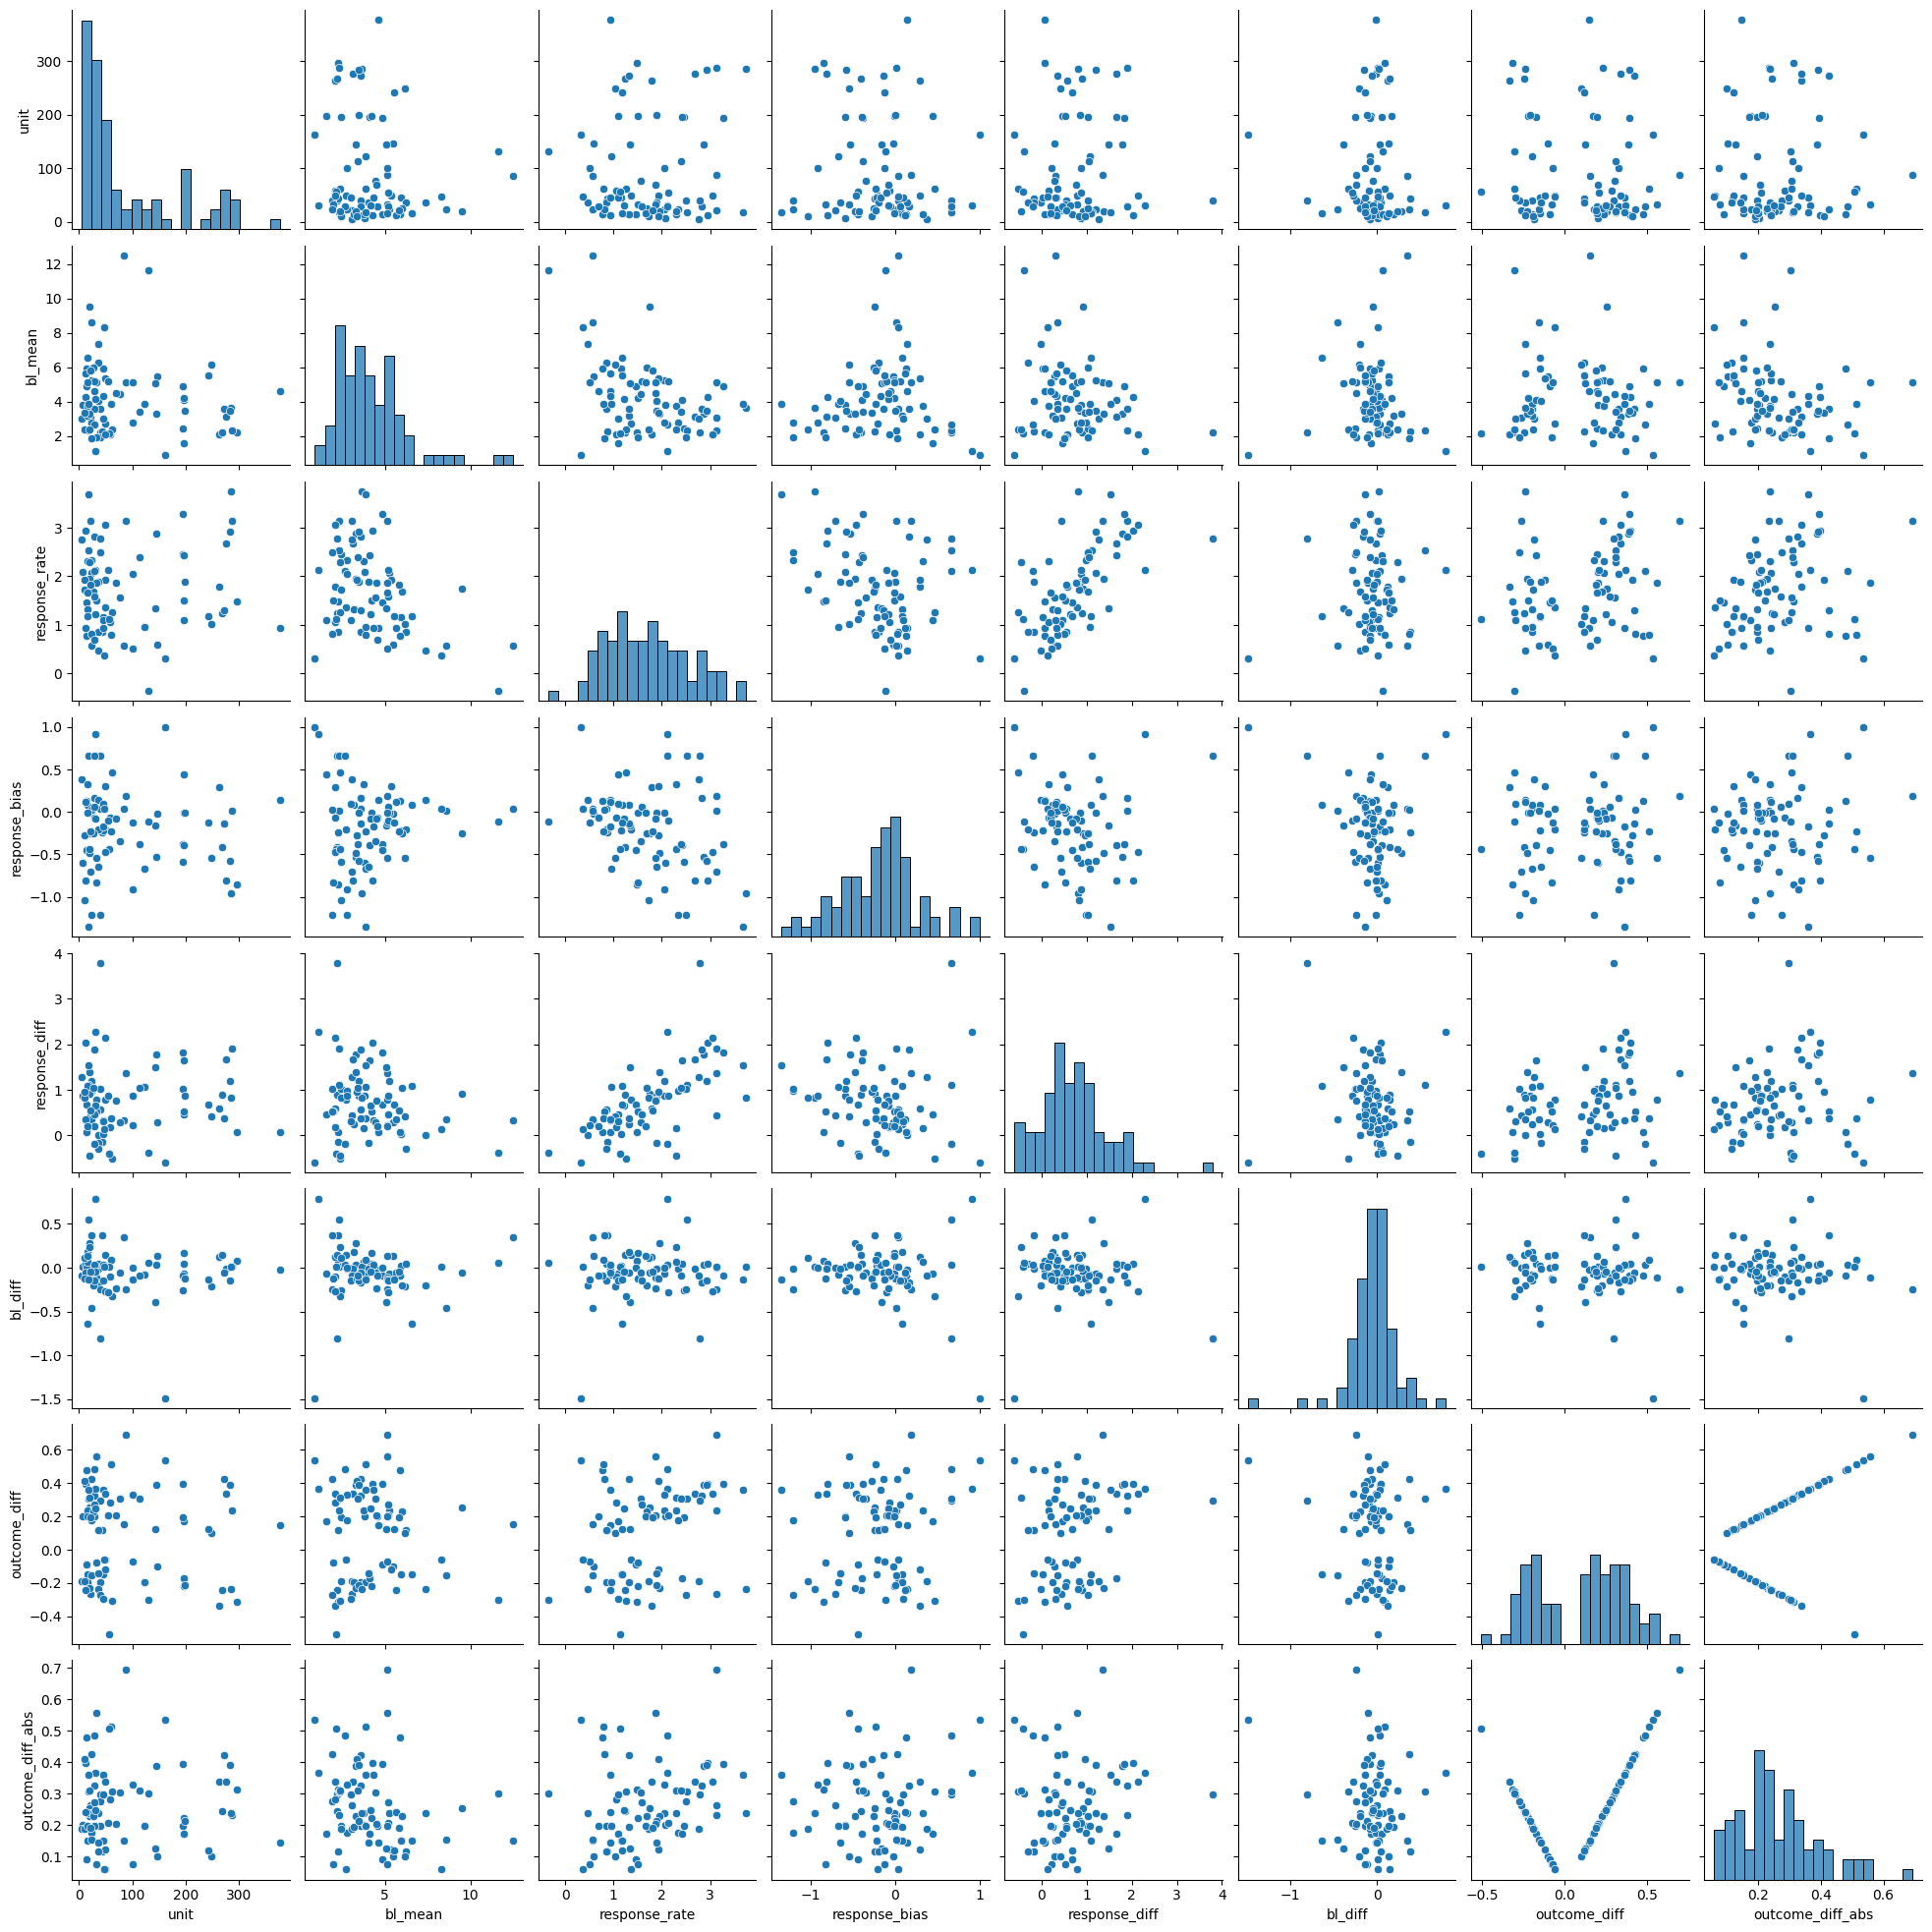

In [114]:
sns.pairplot(data=basic_ephys_df, diag_kws={'bins': 20},)

T-statistic: 2.206131524382385, P-value: 0.030279884814446826, Degrees of freedom: 79.0


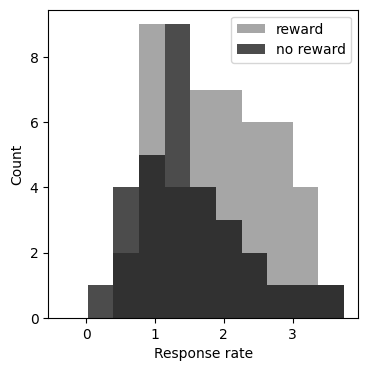

In [303]:
bins = np.linspace(basic_ephys_df['response_rate'].min(), basic_ephys_df['response_rate'].max(), 12)
plt.figure(figsize=(4, 4))
plt.hist(basic_ephys_df[(basic_ephys_df['outcome_diff']>0) & filter]['response_rate'], bins=bins, alpha=0.7, color='gray', label='reward')
plt.hist(basic_ephys_df[(basic_ephys_df['outcome_diff']<0) & filter]['response_rate'], bins=bins, alpha=0.7, color='k', label='no reward')
plt.xlabel('Response rate')
plt.ylabel('Count')
plt.legend()
# tstats
from statsmodels.stats.weightstats import ttest_ind
reward_response = basic_ephys_df[basic_ephys_df['outcome_diff']>0]['response_rate']
no_reward_response = basic_ephys_df[basic_ephys_df['outcome_diff']<0]['response_rate']
t_stat, p_value, df = ttest_ind(reward_response, no_reward_response, usevar='pooled')
print(f'T-statistic: {t_stat}, P-value: {p_value}, Degrees of freedom: {df}')

T-statistic: -0.42597074859377615, P-value: 0.6712875062440359, Degrees of freedom: 79.0


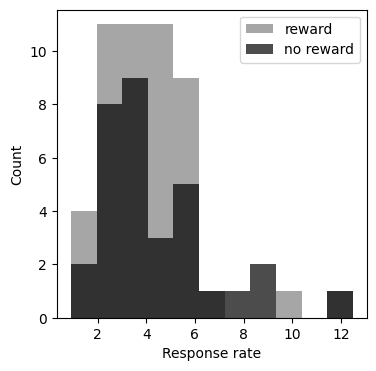

In [116]:
tar_var = 'bl_mean'
bins = np.linspace(basic_ephys_df[tar_var].min(), basic_ephys_df[tar_var].max(), 12)
plt.figure(figsize=(4, 4))
plt.hist(basic_ephys_df[basic_ephys_df['outcome_diff']>0][tar_var], bins=bins, alpha=0.7, color='gray', label='reward')
plt.hist(basic_ephys_df[basic_ephys_df['outcome_diff']<0][tar_var], bins=bins, alpha=0.7, color='k', label='no reward')
plt.xlabel('Response rate')
plt.ylabel('Count')
plt.legend()
# tstats
from statsmodels.stats.weightstats import ttest_ind
reward_response = basic_ephys_df[basic_ephys_df['outcome_diff']>0][tar_var]
no_reward_response = basic_ephys_df[basic_ephys_df['outcome_diff']<0][tar_var]
t_stat, p_value, df = ttest_ind(reward_response, no_reward_response, usevar='pooled')
print(f'T-statistic: {t_stat}, P-value: {p_value}, Degrees of freedom: {df}')

Text(0, 0.5, 'abs(Outcome difference (reward - no reward))')

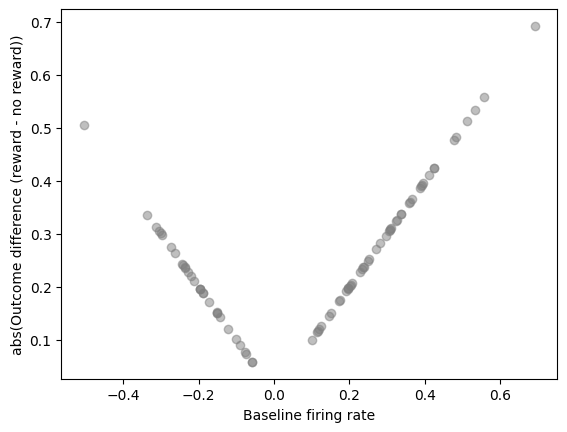

In [117]:
plt.scatter(basic_ephys_df['outcome_diff'], basic_ephys_df['outcome_diff_abs'], alpha=0.5, color='gray', label='all units')
plt.xlabel('Baseline firing rate')
plt.ylabel('abs(Outcome difference (reward - no reward))')

In [273]:
# get all t-stats, coeffs, p-values for the two groups
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
all_bl = []
all_response_rate = []
all_response_bias = []
all_response_diff = []
all_bl_diff = []
all_outcome_diff = []
all_outcome_diff_abs = []

auto_inhi = []

curr_session = None
pre_event = -1.5
post_event = 3
binSize = 0.5

auto_inhi_bin = 0.05
window_length = 2.0

all_acf = []
all_acf_bl = []
all_r2 = []
all_sd = []
all_lens = []

loaded_session = None
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit_id = row['unit']
    # check if different session
    if loaded_session is None or loaded_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session)
        session_df_go_cue = get_session_tbl(session)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
        print(f'Processing session: {session}')
    unit_drift = load_drift(session, unit_id, data_type=data_type)
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    session_df_go_cue_curr = session_df_go_cue.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    all_r2.append(unit_drift['r_squared_slow_corrected'])
    all_sd.append(unit_drift['sd/mean_updated'])
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            session_df_go_cue_curr = session_df_go_cue_curr[session_df_go_cue_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            session_df_go_cue_curr = session_df_go_cue_curr[session_df_go_cue_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    # calculate auto-inhibition
    session_start = session_df_go_cue_curr['goCue_start_time'].values[0]-10
    session_end = session_df_go_cue_curr['goCue_start_time'].values[-1]+20
    all_lens.append(session_end - session_start)
    counts = np.histogram(spike_times_curr, bins=np.arange(session_start, session_end, auto_inhi_bin))[0]
    starts = np.arange(session_start, session_end, auto_inhi_bin)[:-1]
    ends = np.arange(session_start, session_end, auto_inhi_bin)[1:]
    acf = autocorrelation(counts, lag=int(window_length/auto_inhi_bin))
    # remove periods within session
    pre_time = 0
    post_time = 3
    counts_bl = counts.copy().astype(float)
    if len(session_df_go_cue_curr) > 0:
        for ind, row in session_df_go_cue_curr.iterrows():
            start_time = row['goCue_start_time'] - pre_time
            end_time = row['goCue_start_time'] + post_time
            # set counts in this period to np.nan
            mask = (ends >= start_time) & (starts <= end_time)
            if np.sum(mask) > 0:
                counts_bl[mask] = np.nan
    acf_bl = autocorrelation(counts_bl, lag=int(window_length/auto_inhi_bin))
    

    
    all_acf.append(acf)
    all_acf_bl.append(acf_bl)

    

Processing session: behavior_716325_2024-05-31_10-31-14
Processing session: behavior_717121_2024-06-15_10-00-58
Processing session: behavior_751004_2024-12-19_11-50-37
Processing session: behavior_751004_2024-12-20_13-26-11
Processing session: behavior_751004_2024-12-21_13-28-28
Processing session: behavior_751004_2024-12-22_13-09-17
Processing session: behavior_751004_2024-12-23_14-20-03
Processing session: behavior_751769_2025-01-16_11-32-05
Processing session: behavior_751769_2025-01-17_11-37-39
Processing session: behavior_751769_2025-01-18_10-15-25
Processing session: behavior_758017_2025-02-04_11-57-38
Processing session: behavior_758017_2025-02-05_11-42-34
Processing session: behavior_758017_2025-02-06_11-26-14
Processing session: behavior_758017_2025-02-07_14-11-08
Processing session: behavior_751766_2025-02-11_11-53-38
Processing session: behavior_751766_2025-02-13_11-31-21
Processing session: behavior_751766_2025-02-14_11-37-11
Processing session: behavior_751181_2025-02-25_1

In [275]:
all_acf = np.array(all_acf)
all_acf_bl = np.array(all_acf_bl)
all_r2 = np.array(all_r2)
all_sd = np.array(all_sd)
all_lens = np.array(all_lens)

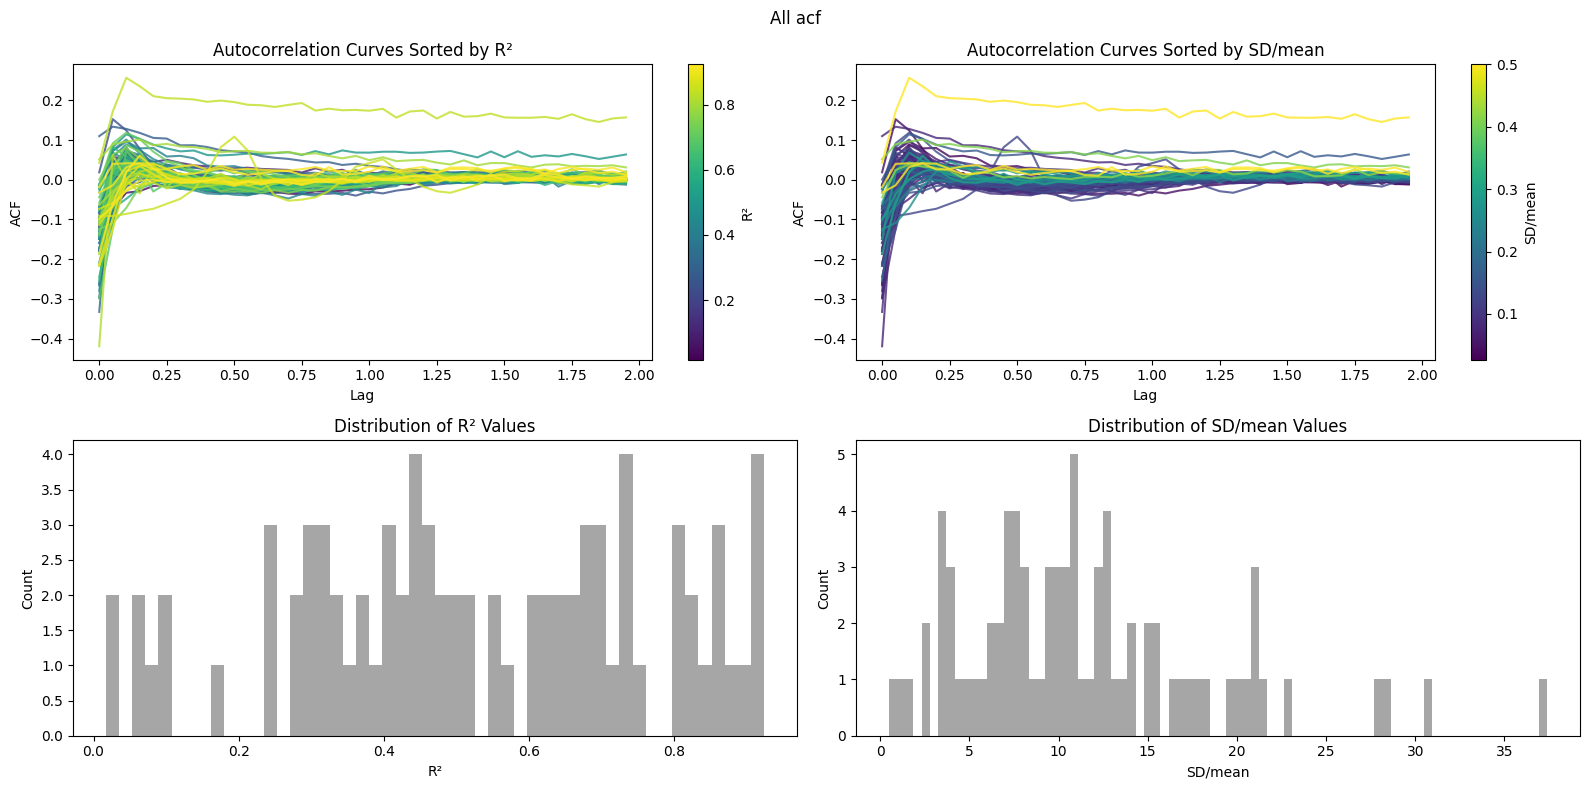

In [283]:
plt.figure(figsize=(16, 8))

ax = plt.subplot(221)

# Prepare x-axis
x_vals = np.array(range(int(window_length/auto_inhi_bin))) * auto_inhi_bin

# Sort by R²
sort_inds = np.argsort(all_r2)
sorted_r2 = all_r2[sort_inds]



# Normalize colormap
norm = mcolors.Normalize(vmin=np.min(all_r2), vmax=np.max(all_r2))
cmap = cm.viridis
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create plot
for idx in sort_inds:
    # if all_acf[idx, -1]>0.05:
    #     continue
    ax.plot(x_vals, all_acf[idx, 1:], color=cmap(norm(all_r2[idx])), alpha=0.8, linewidth=1.5)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('R²')

# Labels
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
ax.set_title('Autocorrelation Curves Sorted by R²')

ax = plt.subplot(222)


# Sort by R²
sort_inds = np.argsort(all_sd)
sorted_sd = all_sd[sort_inds]

# Normalize colormap
norm = mcolors.Normalize(vmin=np.min(all_sd), vmax=0.5)
cmap = cm.viridis
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create plot
for idx in sort_inds:
    # if all_acf[idx, -1]>0.05:
    #     continue
    ax.plot(x_vals, all_acf[idx, 1:], color=cmap(norm(all_sd[idx])), alpha=0.8, linewidth=1.5)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('SD/mean')

# Labels
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
ax.set_title('Autocorrelation Curves Sorted by SD/mean')

ax = plt.subplot(223)
ax.hist(x=all_r2, bins=50, color='gray', alpha=0.7)

ax.set_xlabel('R²')
ax.set_ylabel('Count')
ax.set_title('Distribution of R² Values')
ax = plt.subplot(224)
ax.hist(x=1/all_sd, bins=80, color='gray', alpha=0.7)
ax.set_xlabel('SD/mean')
ax.set_ylabel('Count')
ax.set_title('Distribution of SD/mean Values')

plt.suptitle('All acf')
plt.tight_layout()
plt.show()


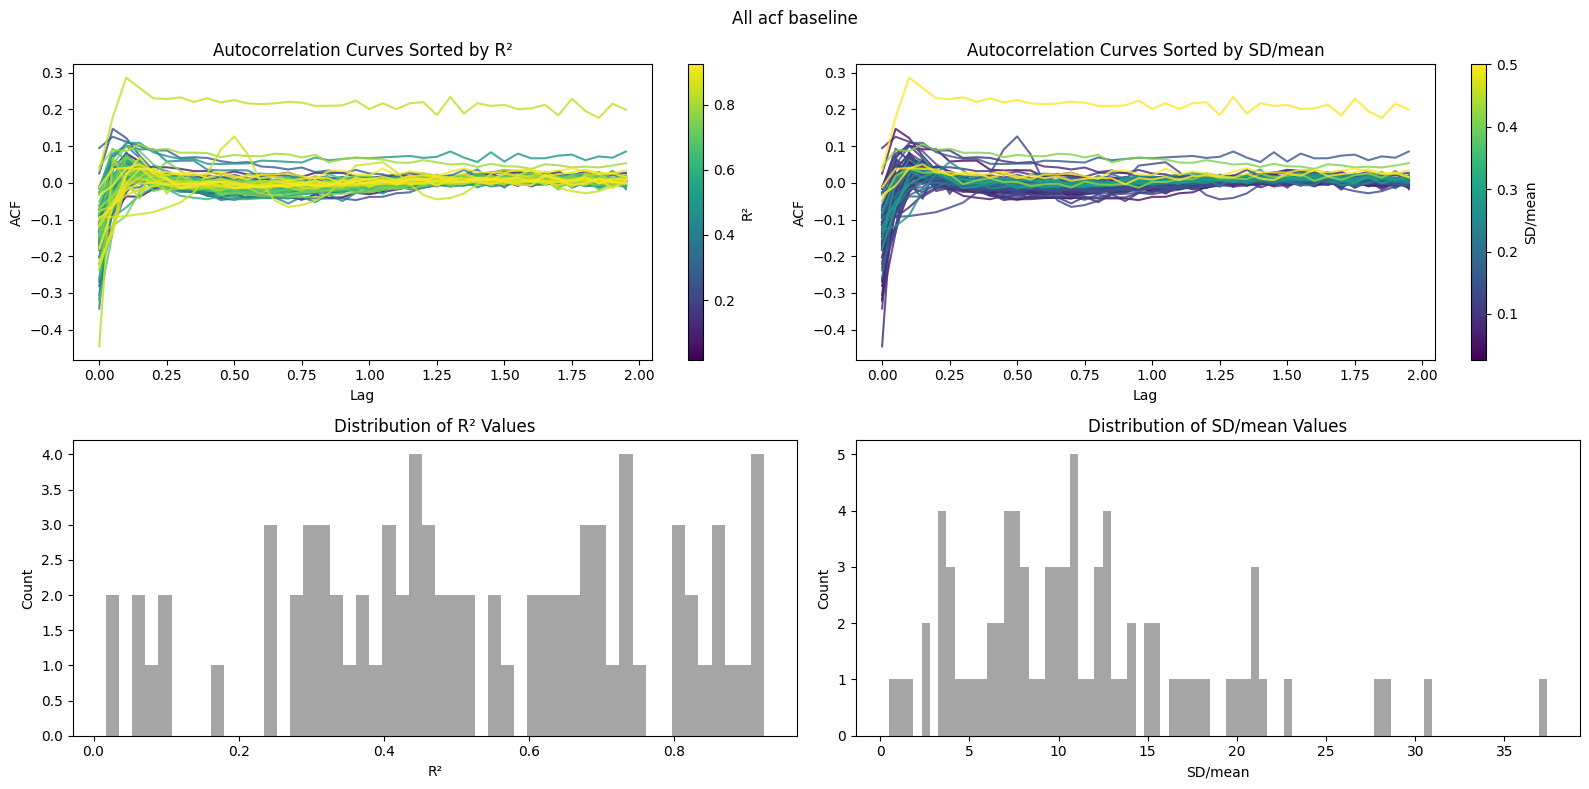

In [278]:
plt.figure(figsize=(16, 8))

ax = plt.subplot(221)

# Prepare x-axis
x_vals = np.array(range(int(window_length/auto_inhi_bin))) * auto_inhi_bin

# Sort by R²
sort_inds = np.argsort(all_r2)
sorted_r2 = all_r2[sort_inds]



# Normalize colormap
norm = mcolors.Normalize(vmin=np.min(all_r2), vmax=np.max(all_r2))
cmap = cm.viridis
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create plot
for idx in sort_inds:
    # if all_acf[idx, -1]>0.05:
    #     continue
    ax.plot(x_vals, all_acf_bl[idx, 1:], color=cmap(norm(all_r2[idx])), alpha=0.8, linewidth=1.5)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('R²')

# Labels
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
ax.set_title('Autocorrelation Curves Sorted by R²')

ax = plt.subplot(222)


# Sort by R²
sort_inds = np.argsort(all_sd)
sorted_sd = all_sd[sort_inds]

# Normalize colormap
norm = mcolors.Normalize(vmin=np.min(all_sd), vmax=0.5)
cmap = cm.viridis
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Create plot
for idx in sort_inds:
    # if all_acf_bl[idx, -1]>0.05:
    #     continue
    ax.plot(x_vals, all_acf_bl[idx, 1:], color=cmap(norm(all_sd[idx])), alpha=0.8, linewidth=1.5)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('SD/mean')

# Labels
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
ax.set_title('Autocorrelation Curves Sorted by SD/mean')

ax = plt.subplot(223)
ax.hist(x=all_r2, bins=50, color='gray', alpha=0.7)

ax.set_xlabel('R²')
ax.set_ylabel('Count')
ax.set_title('Distribution of R² Values')
ax = plt.subplot(224)
ax.hist(x=1/all_sd, bins=80, color='gray', alpha=0.7)
ax.set_xlabel('SD/mean')
ax.set_ylabel('Count')
ax.set_title('Distribution of SD/mean Values')

plt.suptitle('All acf baseline')
plt.tight_layout()
plt.show()


Text(0, 0.5, 'acf baseline')

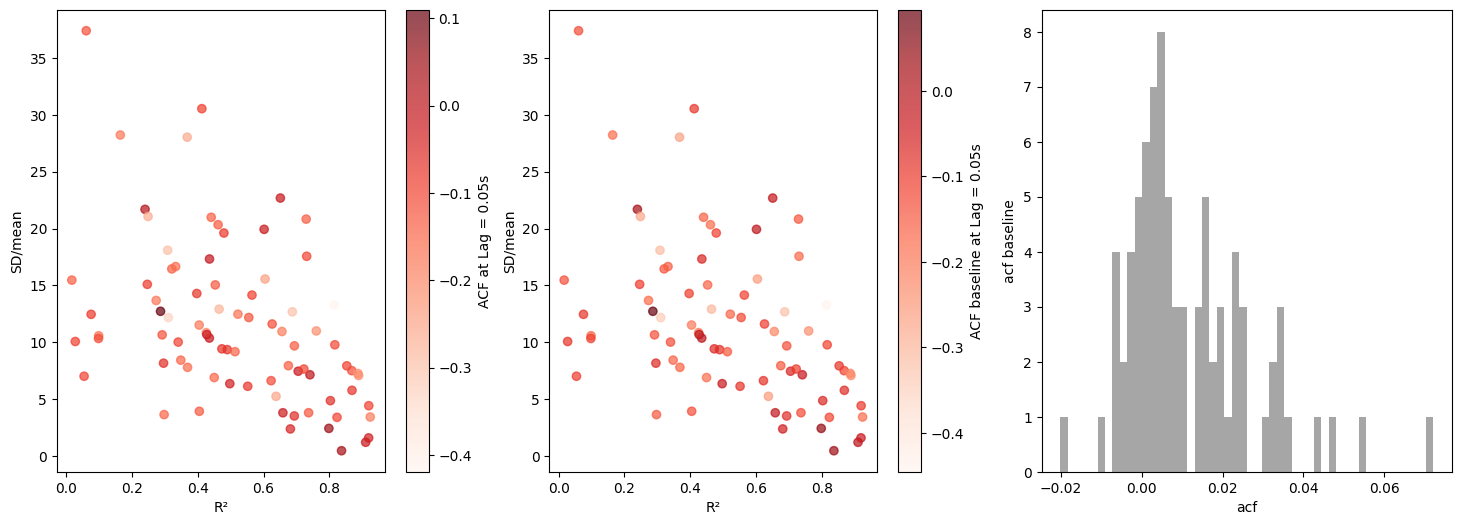

In [287]:
# drift params
filter = all_acf[:, -1] < 1
focus_ind = np.argmin(np.mean(all_acf[filter, 1:], axis=0))+1
focus_ind = 1

norm = mcolors.Normalize(vmin=np.min(all_acf[filter, focus_ind]), vmax=np.max(all_acf[filter, focus_ind]))
# norm = mcolors.Normalize(vmin=np.min(all_lens), vmax=np.max(all_lens))
cmap = cm.Reds
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
fig = plt.figure(figsize=(18, 6))
plt.subplot(131)
sc = plt.scatter(all_r2, 1/all_sd, c=all_acf[filter, focus_ind], cmap=cmap, norm=norm, alpha=0.7)
plt.xlabel('R²')
plt.ylabel('SD/mean')
cbar = plt.colorbar(sc)
cbar.set_label('ACF at Lag = {:.2f}s'.format(focus_ind * auto_inhi_bin))

plt.subplot(132)
cmap = cm.Reds
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
norm = mcolors.Normalize(vmin=np.min(all_acf_bl[filter, focus_ind]), vmax=np.max(all_acf_bl[filter, focus_ind]))
sc = plt.scatter(all_r2, 1/all_sd, c=all_acf_bl[filter, focus_ind], cmap=cmap, norm=norm, alpha=0.7)
plt.xlabel('R²')
plt.ylabel('SD/mean')
cbar = plt.colorbar(sc)
cbar.set_label('ACF baseline at Lag = {:.2f}s'.format(focus_ind * auto_inhi_bin))

plt.subplot(133)
# plt.scatter(all_acf[:, focus_ind], all_acf[:, focus_ind], s = 10)
# plt.plot([-0.3, 0.3], [-0.3, 0.3], color='k', linestyle='--', alpha=0.5, linewidth=1.5)
plt.hist(all_acf[:, focus_ind]-all_acf_bl[:, focus_ind], bins=50, color='gray', alpha=0.7)
plt.xlabel('acf')
plt.ylabel('acf baseline')

Text(0.5, 1.0, 'Focus time: 0.05 s')

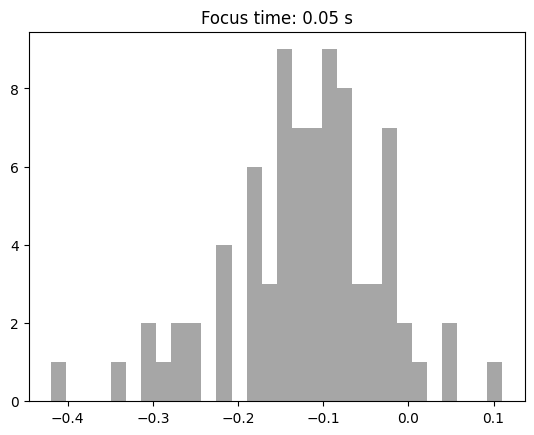

In [290]:
filter = all_acf[:, -1] < 1
focus_ind = np.argmin(np.mean(all_acf[filter, 1:], axis=0))+1
focus_ind = 1
plt.hist(all_acf[filter, focus_ind], bins=30, color='gray', alpha=0.7, label='ACF at last lag');
plt.title(f'Focus time: {x_vals[focus_ind]:.2f} s')

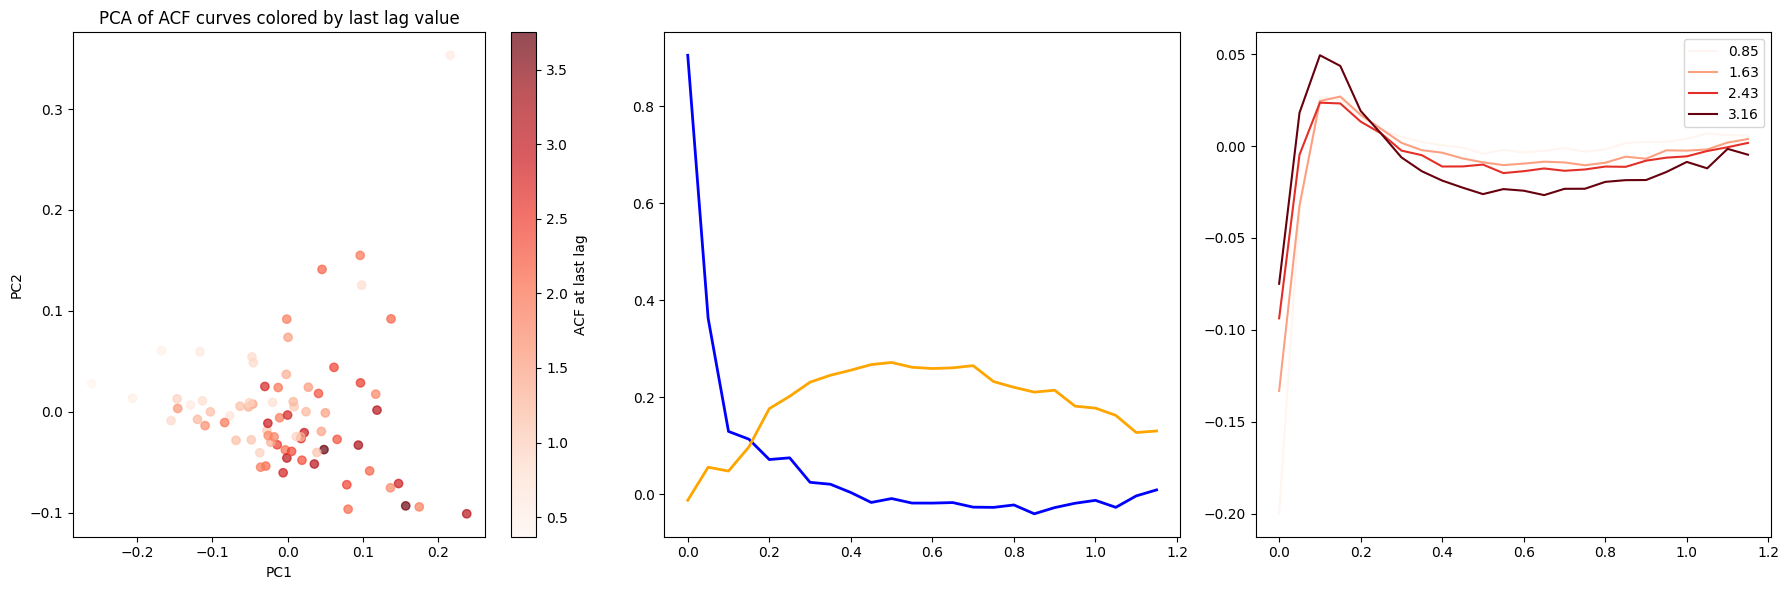

In [302]:
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Assume all_acf and filter are defined appropriately
# Example dummy structure:
# all_acf = np.random.rand(100, 20)
filter = (all_acf[:, -1] < 0.05) & (combined_tagged_units_filtered['unit']!=131) & ~((combined_tagged_units_filtered['unit']==197) & (combined_tagged_units_filtered['session']=="behavior_716325_2024-05-31_10-31-14"))

# Normalize and colormap for color mapping
focus_feature = 'response_rate'
color_values = basic_ephys_df[focus_feature].values[filter]
focus_values = basic_ephys_df[focus_feature].values[filter]
norm = mcolors.Normalize(vmin=np.min(color_values), vmax=np.max(color_values))
cmap = cm.Reds

# Perform PCA
pca = PCA(n_components=3)
end_ind = 25
pca_result = pca.fit_transform(all_acf_bl[filter, 1:end_ind])
# recontruct the ACF curves by pca scores
pca_reconstructed = pca.inverse_transform(pca_result)

# Create scatter plot
plt.figure(figsize=(18, 6))
plt.subplot(131)
sc = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=color_values, cmap=cmap, norm=norm, alpha=0.7)

# Create and link colorbar
cbar = plt.colorbar(sc)
cbar.set_label('ACF at last lag')

# Labels
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of ACF curves colored by last lag value')


plt.subplot(132)
# plot the 2 pcs
plt.plot(x_vals[:end_ind-1], pca.components_[0], label='PC1', color='blue', linewidth=2)
plt.plot(x_vals[:end_ind-1], pca.components_[1], label='PC2', color='orange', linewidth=2)

plt.subplot(133)
# bin acf by focus feature and plot mean
numbins = 4
bins = np.linspace(np.min(focus_values), np.max(focus_values), numbins+1)
# bins = np.quantile(focus_values, np.linspace(0, 1, numbins+1))
bin_means = []
acf_means = []
for i in range(numbins):
    bin_mask = (focus_values >= bins[i]) & (focus_values < bins[i+1])
    bin_means.append(np.mean(focus_values[bin_mask]))
    # acf_means.append(np.mean(pca_reconstructed[bin_mask, :], axis=0))
    acf_means.append(np.mean(all_acf_bl[filter][bin_mask, 1:end_ind], axis=0))

colors = cmap(np.linspace(0, 1, numbins))
for i in range(numbins):
    plt.plot(x_vals[:end_ind-1], acf_means[i], color=colors[i], label = f'{bin_means[i]:.2f}')

plt.legend()
plt.tight_layout()



                                session   unit   bl_mean  response_rate  \
1   behavior_716325_2024-05-31_10-31-14  197.0  1.593857       1.101801   
28  behavior_758017_2025-02-04_11-57-38  197.0  4.222874       1.511135   

    response_bias  response_diff   bl_diff  outcome_diff  outcome_diff_abs  
1        0.444405       0.470254 -0.070294      0.172718          0.172718  
28      -0.007140       0.530214  0.164780     -0.221598          0.221598  


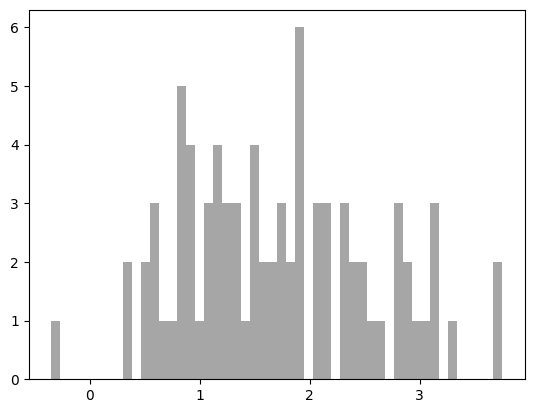

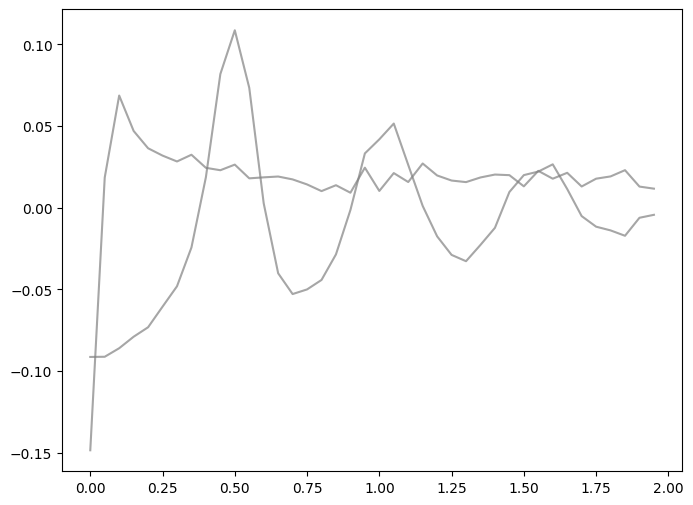

In [267]:
plt.hist(basic_ephys_df['response_rate'], bins=50, color='gray', alpha=0.7);
test_df = basic_ephys_df.query('unit == 197')
print(test_df.head(5))
plt.figure(figsize=(8, 6))
plt.plot(x_vals, all_acf[test_df.index, 1:].T, color='gray', alpha=0.7, label='All units');

In [214]:
all_acf[test_df.index, 1:]

array([[0.10997187, 0.13371106, 0.12807681, 0.11811143, 0.10551483,
        0.10379641, 0.08681832, 0.08698848, 0.08244979, 0.07443575,
        0.07155901, 0.0684049 , 0.05978652, 0.05537336, 0.05260975,
        0.04783165, 0.0436579 , 0.04445721, 0.03726174, 0.04042844,
        0.03495805, 0.03249661, 0.02661055, 0.02146715, 0.0255024 ,
        0.02243661, 0.0187537 , 0.01911253, 0.01728061, 0.01563774,
        0.01302484, 0.01616598, 0.00912159, 0.00623207, 0.00304038,
        0.00987072, 0.0068677 , 0.0111044 , 0.00460122, 0.0006417 ]])

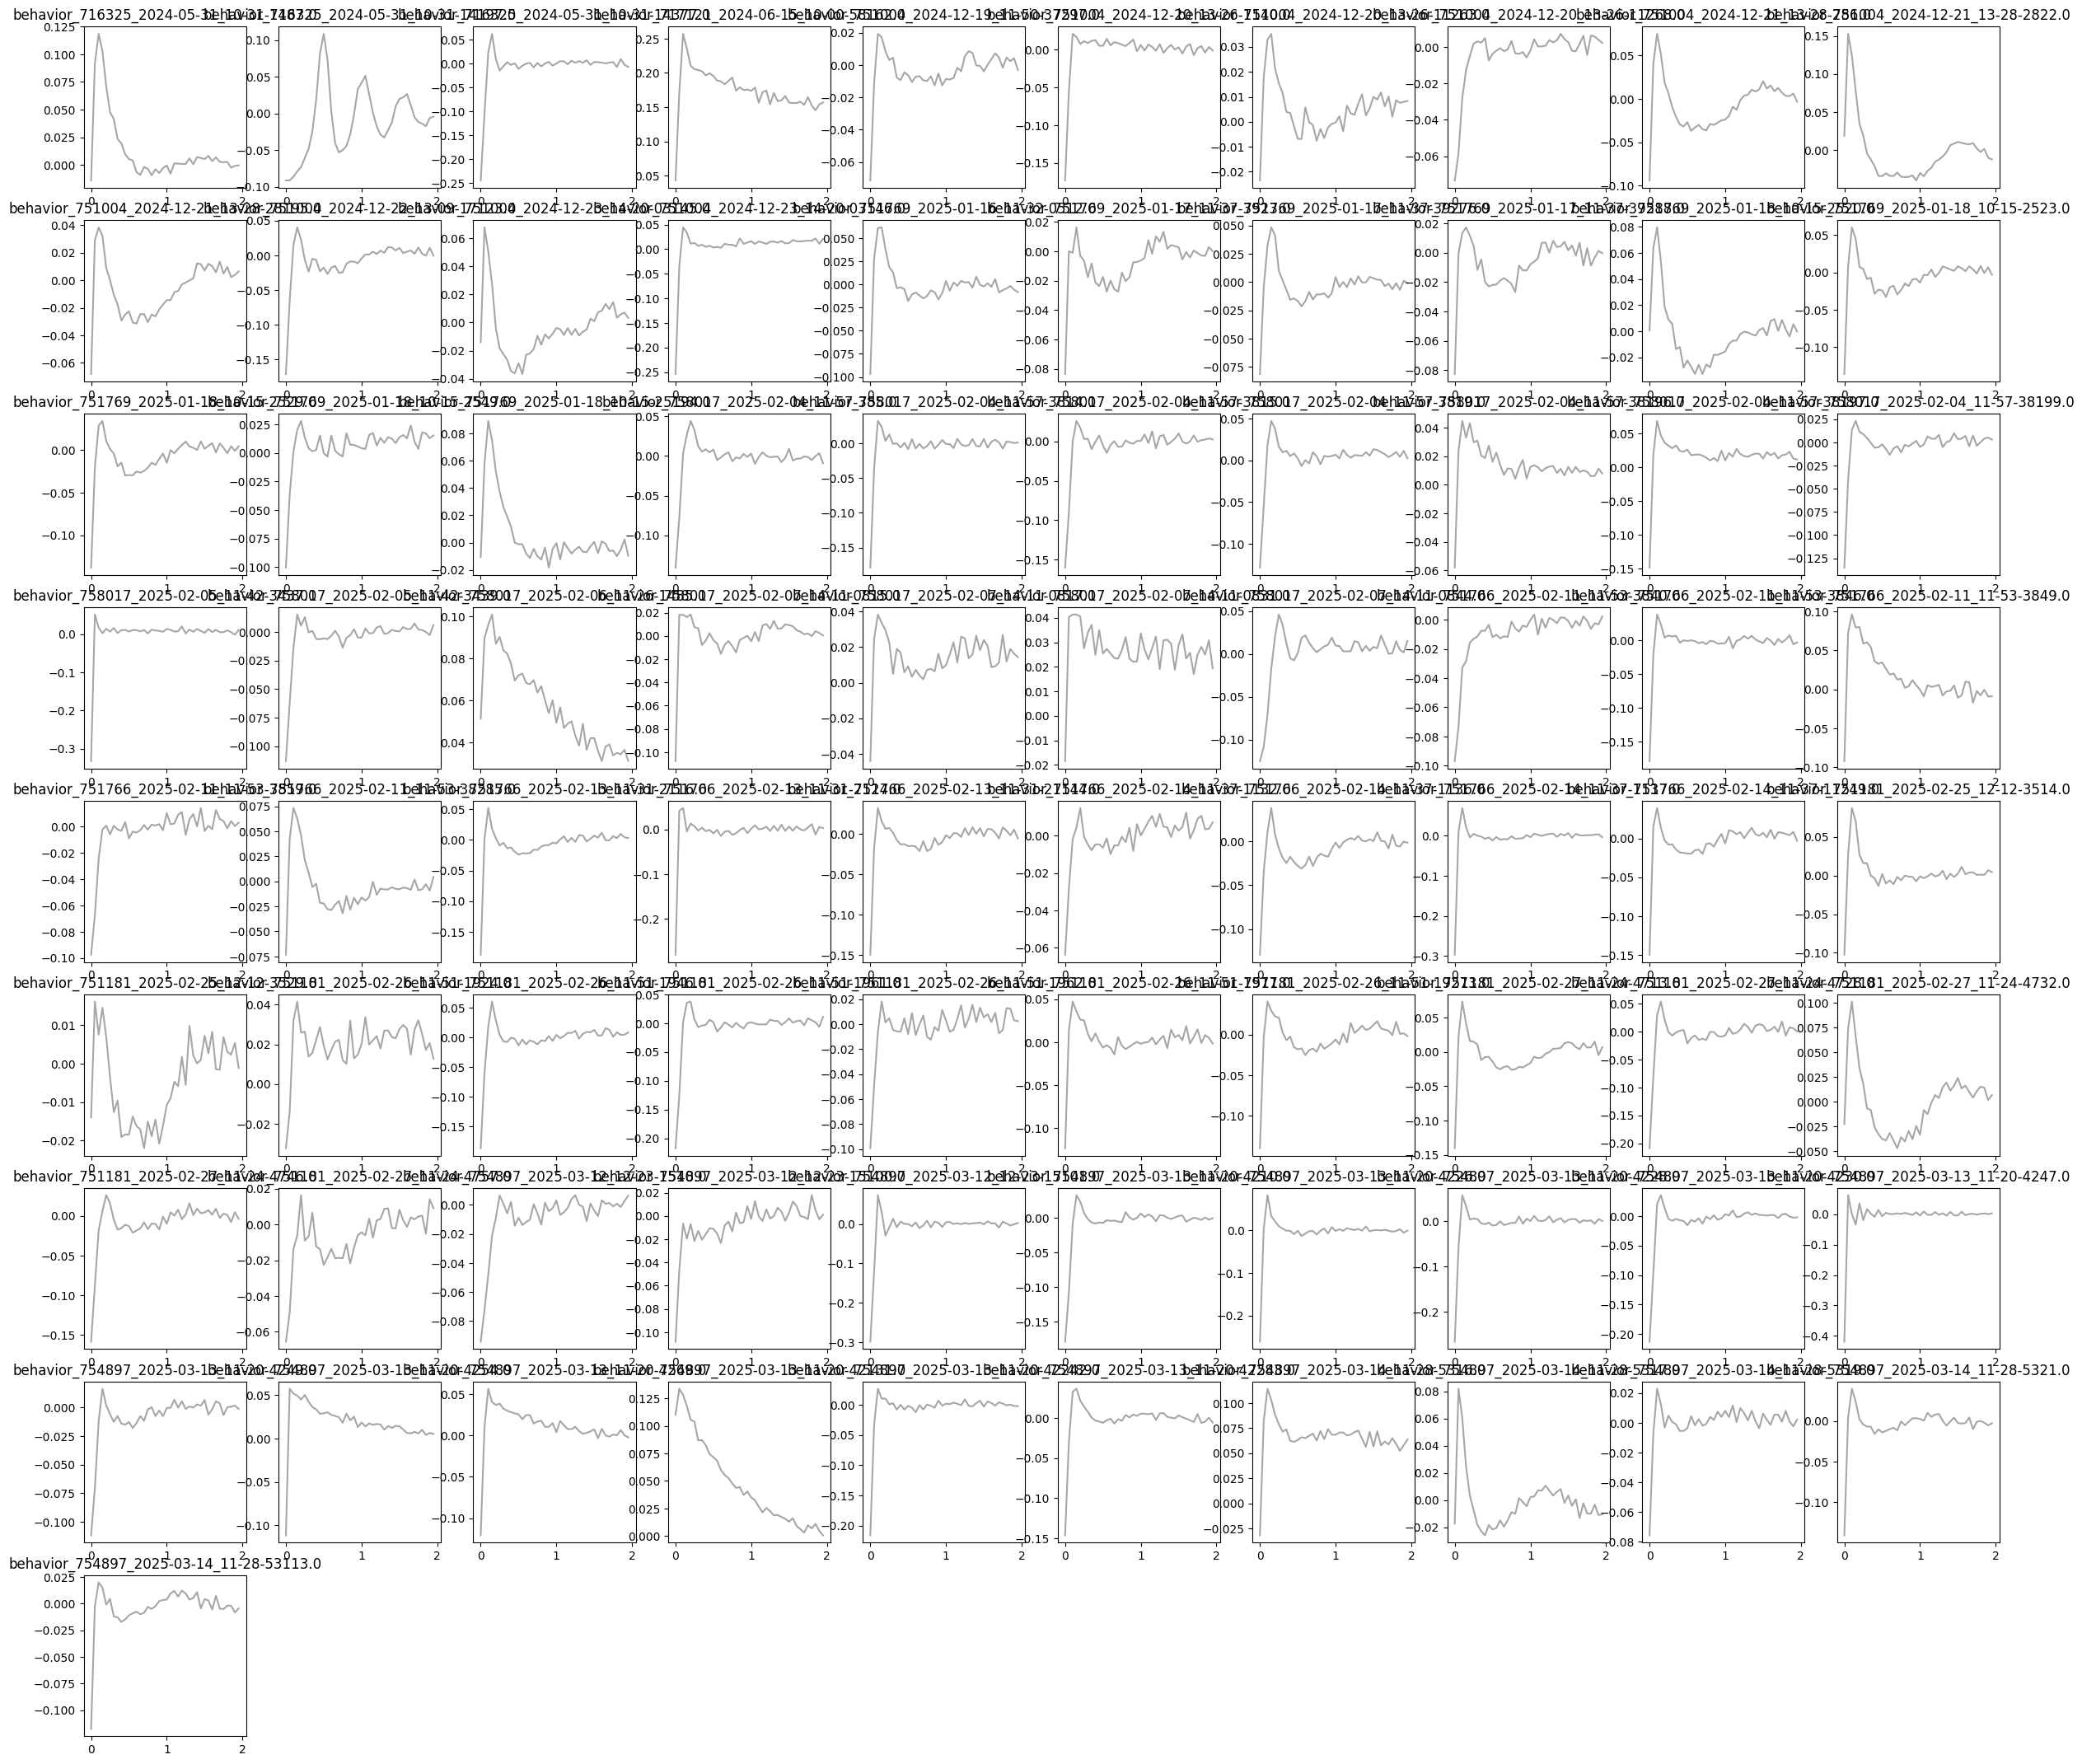

In [187]:
# plot all acf with their id
plt.figure(figsize=(30, 30))
for i in range(len(all_acf)):
    ax = plt.subplot(10, 10, i+1)
    ax.plot(x_vals, all_acf[i, 1:], color='gray', alpha=0.7)
    ax.set_title(combined_tagged_units_filtered.iloc[i]['session'] + str(combined_tagged_units_filtered.iloc[i]['unit']))